## Dependencies

In [4]:
%gui qt5
# needed to launch a PyQt5 application (napari)

import numpy as np
from dask_image.imread import imread
import scipy.io
import pandas as pb
import napari

## Loading the data
We are using the `dask-image` package to load a *Paraphronima crassipes* DICOM dataset and the `napari` package to visualise this data.

In [5]:
stack = imread("P_crassipes_FEG191022_077A/new/*.dcm")

Let's inspect the data:

In [6]:
stack

dask.array<concatenate, shape=(611, 652, 441), dtype=int16, chunksize=(1, 652, 441), chunktype=numpy.ndarray>

Let's read in the annotated point data and add this to the plot

In [7]:
mat = scipy.io.loadmat('P_crassipes_FEG191022_077A.mat')

In [8]:
type(mat)
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'save_dat', '__function_workspace__'])

In [9]:
classification = pb.DataFrame(mat['save_dat'][0]['data'][0][0][0][0]).iloc[:,5]
points = pb.DataFrame(mat['save_dat'][0]['data'][0][0][0][0]).iloc[:,[2, 0, 1]]
points.columns = ['x', 'y', 'z']
points

,x,y,z
0,40.481631,147.725003,199.015571
1,267.238732,79.774611,154.688388
2,40.195919,144.879549,247.636955
3,25.693888,181.412526,214.614645
4,257.335501,88.203109,153.242276
...,...,...,...
420,351.756917,141.633198,131.476212
421,348.101522,138.402087,123.711460
422,355.190020,137.432012,116.417385
423,389.251064,189.948370,131.885950


In [10]:
# convert back to numpy array
points = np.array(points)

In [11]:
np.unique(classification)

array([0., 1., 2., 3.])

## Plotting the data
Now let's view the volumetric data using napari

In [12]:
# setup the viewer
viewer = napari.Viewer()
viewer.dims.ndisplay = 3 # toggle 3 dimensional view

viewer.add_image(stack, contrast_limits=(18000, 32800))

<Image layer 'stack' at 0x1498b7588>

Lets see what classifications are what

In [11]:
viewer.add_points(points[classification==0,:], name='0')
viewer.add_points(points[classification==1,:], name='1')
viewer.add_points(points[classification==2,:], name='2')
viewer.add_points(points[classification==3,:], name='3')

<Points layer '3' at 0x1494469e8>

0 = Cornea
1 = Rhabdom
2 = Cornea
3 = Rhabdom

Let's plot a rhabdom

In [13]:
buffer = 30

# rhabdom
point_row = 50

x_min = round(points[point_row, 0] - buffer)
x_max = round(points[point_row, 0] + buffer)
y_min = round(points[point_row, 1] - buffer)
y_max = round(points[point_row, 1] + buffer)
z_min = round(points[point_row, 2] - buffer)
z_max = round(points[point_row, 2] + buffer)
cube_around_point = stack[x_min:x_max, y_min:y_max, z_min:z_max]

# setup the viewer
cube_viewer = napari.Viewer()
cube_viewer.dims.ndisplay = 3 # toggle 3 dimensional view

cube_viewer.add_image(cube_around_point, contrast_limits=(18000, 32800))

<Image layer 'cube_around_point' at 0x147c8f240>

Now lets plot a cornea

In [14]:
buffer = 30

# cornea
point_row = 200

x_min = round(points[point_row, 0] - buffer)
x_max = round(points[point_row, 0] + buffer)
y_min = round(points[point_row, 1] - buffer)
y_max = round(points[point_row, 1] + buffer)
z_min = round(points[point_row, 2] - buffer)
z_max = round(points[point_row, 2] + buffer)
cube_around_point = stack[x_min:x_max, y_min:y_max, z_min:z_max]

# setup the viewer
cube_viewer = napari.Viewer()
cube_viewer.dims.ndisplay = 3 # toggle 3 dimensional view

cube_viewer.add_image(cube_around_point, contrast_limits=(18000, 32800))

<Image layer 'cube_around_point' at 0x14759a550>

# Data preparation

Let's simplify our classifications to just Cornea and Rhabdom

In [10]:
cornea_indx = (classification==0) | (classification==2)
rhabdom_indx = (classification==1) | (classification==3)

## Creation of probability volumes that we are trying to predict

We will attempt to predict values contained in a probability matrix using a CNN

First we will create an empty matrix the size of the original data

In [11]:
empty = stack.compute()
empty[:,:,:] = 0
np.unique(empty)

array([0], dtype=int16)

In [12]:
empty.shape

(611, 652, 441)

Next we get the coordinates of the manually classified points and set their corresponding areas in the empty array to 1

first round coordinates to their nearest pixel

In [13]:
points = np.round(points).astype(int)
points

array([[ 40, 148, 199],
       [267,  80, 155],
       [ 40, 145, 248],
       ...,
       [355, 137, 116],
       [389, 190, 132],
       [481, 228, 109]])

In [14]:
corneas = empty.copy()
rhabdoms = empty.copy()

corneas[points[cornea_indx, 0], points[cornea_indx, 1], points[cornea_indx, 2]] = 1
rhabdoms[points[rhabdom_indx, 0], points[rhabdom_indx, 1], points[rhabdom_indx, 2]] = 1

In [15]:
np.unique(empty, return_counts=True)

(array([0], dtype=int16), array([175682052]))

Quick plot to check manually labelled points are correct

In [20]:
# setup the viewer
viewer = napari.Viewer()
viewer.dims.ndisplay = 3 # toggle 3 dimensional view

viewer.add_image(corneas, colormap='cyan')
viewer.add_image(rhabdoms, colormap='magma')

viewer.add_image(stack, contrast_limits=(18000, 32800), opacity=0.3)

<Image layer 'stack' at 0x14bbdca58>

Now calculate a distance matrix from our manually selected points

In [16]:
from scipy.ndimage.morphology import distance_transform_edt

cornea_dist = distance_transform_edt(1-corneas)
rhabdom_dist = distance_transform_edt(1-rhabdoms)

And use these to calculate two probability matrices for corneas and rhabdoms. To do this, we use the following equation:

$probability = \frac{max \space distance \space - \space distance}{max \space distance}$

We will use a max distance of 30 (voxels)

In [17]:
max_distance = 30

cornea_prob = (max_distance - cornea_dist) / max_distance
rhabdom_prob = (max_distance - rhabdom_dist) / max_distance
cornea_prob[cornea_prob < 0] = 0
rhabdom_prob[rhabdom_prob < 0] = 0

Now these are calculated, we will make a quick plot to make sure they visually line up with our micro-ct data

In [ ]:
viewer.add_image(cornea_prob, colormap='cyan', opacity=0.5, contrast_limits=(0.01, 1))
viewer.add_image(rhabdom_prob, colormap='magma', opacity=0.5, contrast_limits=(0.01, 1))

Should look like this:

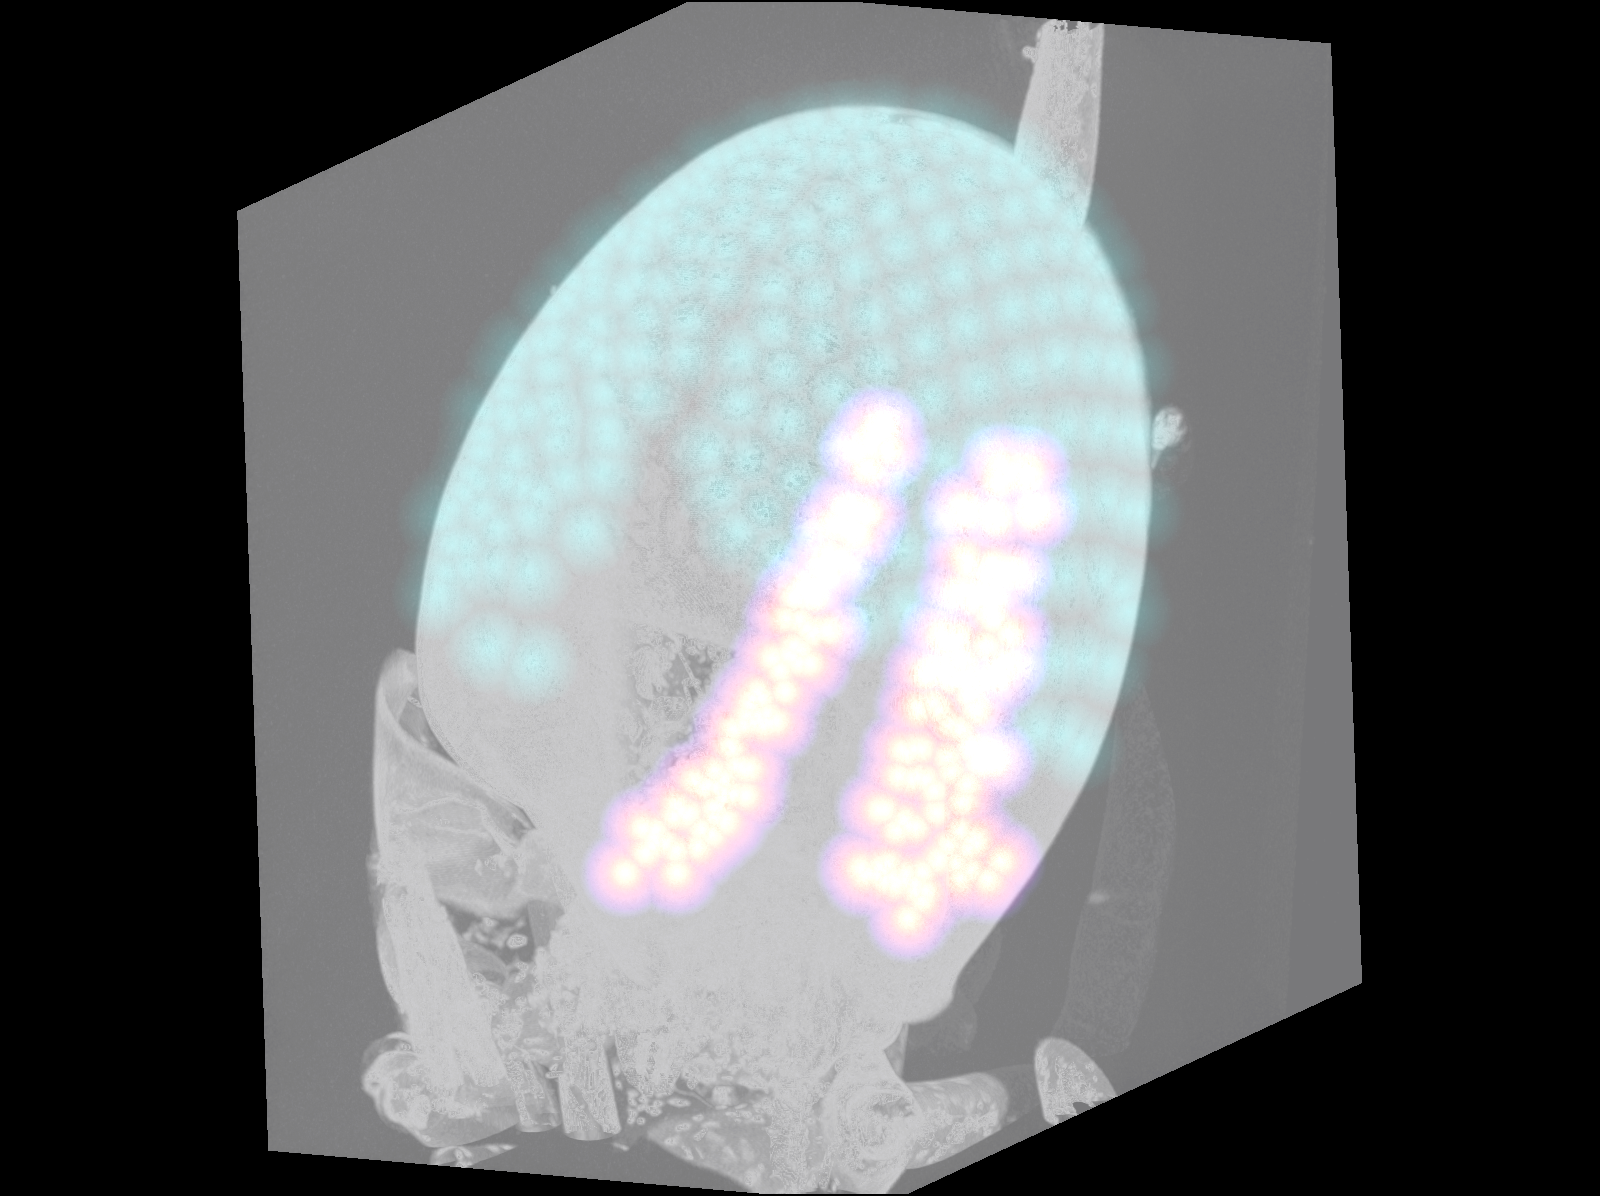

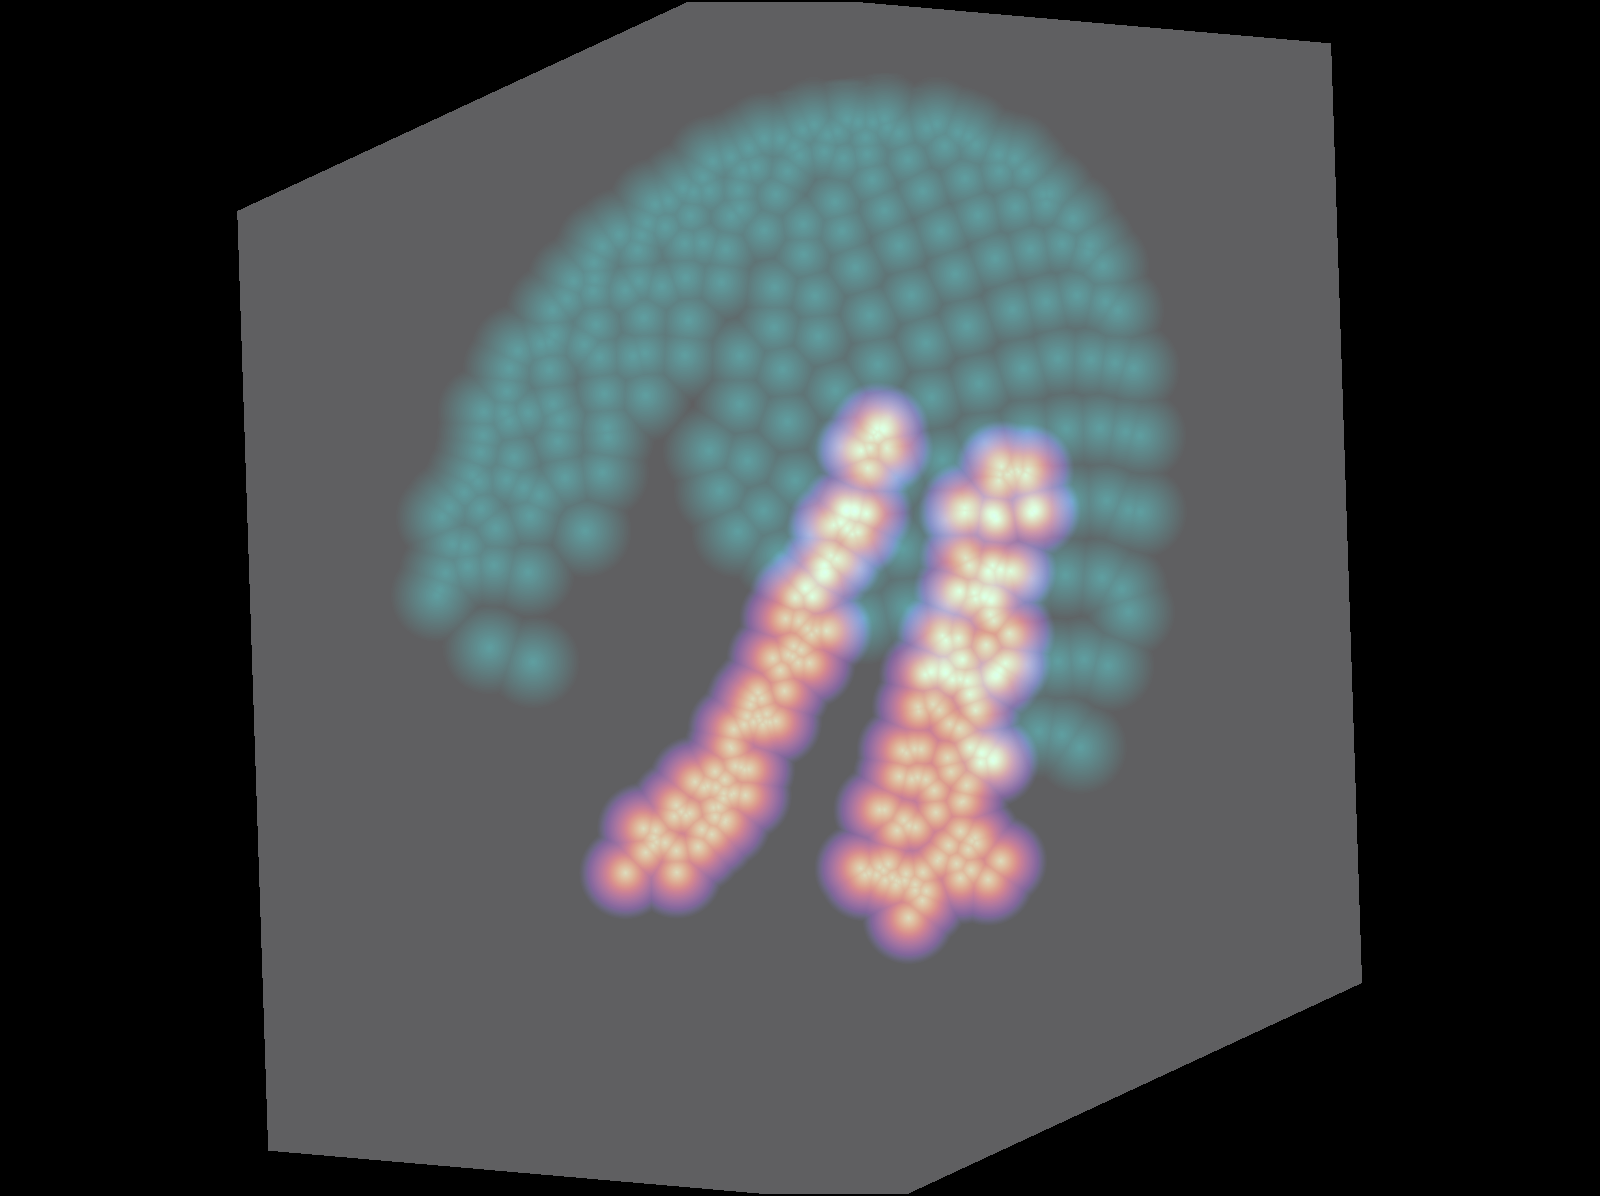

## Create training data and save

### Rotation

We can rotate the dataset to increase the number of training data points and to also make sure the network can identify our structures at different angles.

We can use the ndimage.rotate function from the scipy package to rotate our volumetric data.

We can rotate by a certain angle along different axes with (1, 0), (1, 2) and (0, 2).

We must also remember to rotate our cornea and rhabdom probabilities to preserve the classifications of the newly rotated data

In [ ]:
from scipy.ndimage import rotate

angle = 25
axes = (1,0)

# rotate whole dataset 
stack_y_25 = rotate(stack, angle, axes=axes)
# plot
#viewer.add_image(stack_y_25, contrast_limits=(18000, 32800))

# rotate probabilities
cornea_prob_y_25 = rotate(cornea_prob, angle, axes=axes)
rhabdom_prob_y_25 = rotate(rhabdom_prob, angle, axes=axes)

# plot
#viewer.add_image(cornea_prob_y_25, opacity=0.5, contrast_limits=(0.01, 1))
#viewer.add_image(rhabdom_prob_y_25, opacity=0.5, contrast_limits=(0.01, 1))

### Now do a sliding window operation

But first, we should add a buffer that is proportionate to window_size

In [36]:
# add buffer around dataset to allow for edges of data to be analysed

We are using `view_as_windows`, which means that any changes to the windowed data changes the original, unwindowed data. This function can then be useful for writing predictions from the neural network to the original dataset.

In [18]:
import numpy as np
from skimage.util.shape import view_as_windows

window_size = 31
window_dims = (window_size, window_size, window_size)
step_size = 1

unwindowed_d = stack.compute()

unwindowed_d.shape

(611, 652, 441)

In [19]:

window_d = view_as_windows(unwindowed_d, window_dims, step_size)
window_rhabdom_prob = view_as_windows(rhabdom_prob, window_dims, step_size)
window_cornea_prob = view_as_windows(cornea_prob, window_dims, step_size)

window_d.shape

(581, 622, 411, 31, 31, 31)

In [ ]:
def convert_6d_to_4d(d):
    d_dims = d.shape
    if len(d_dims) != 6:
        raise Exception('convert_6d_to_4d() requires d to have 6 dimensions')
    # colapse to 4D array (list of 3d arrays)
    d = d.reshape(d_dims[0]*d_dims[1]*d_dims[2], d_dims[3], d_dims[4], d_dims[5])
    return d

window_d = convert_6d_to_4d(window_d)
window_rhabdom_prob = convert_6d_to_4d(window_rhabdom_prob)
window_cornea_prob = convert_6d_to_4d(window_cornea_prob)

window_d.shape

assuming dimensions of (3, 3, 3, x, y, z)) where the first three dimensions are position information (related to both window_size and step_size) and the last x y z are sizes of windows, the above function reorders like:
```
B[0, 0, 0, :, :, :] == C[0, :, :, :])
B[0, 0, 1, :, :, :] == C[1, :, :, :])
B[0, 0, 2, :, :, :] == C[2, :, :, :])
B[0, 1, 0, :, :, :] == C[3, :, :, :])
B[0, 1, 1, :, :, :] == C[4, :, :, :])
B[0, 1, 2, :, :, :] == C[5, :, :, :])
B[0, 2, 0, :, :, :] == C[6, :, :, :])
```

Now, using window_rhabdom_prob and window_cornea_prob, we can create a 3 dimensional array that has the probabilities needed for training a neural network

In [ ]:
validation_d = np.column_stack(
    (
        window_cornea_prob[:, 15, 15, 15],
        window_rhabdom_prob[:, 15, 15, 15]
    )
)

In [ ]:
validation_d.shape

In [ ]:
pb.DataFrame(validation_d)

In [ ]:
rhabdom_indx = np.where(validation_d[:, 1] > 0.85)[0][0]
rhabdom_indx

In [ ]:
import napari

# setup the viewer
viewer = napari.Viewer()
viewer.dims.ndisplay = 3 # toggle 3 dimensional view

viewer.add_image(window_d[rhabdom_indx, :, :, :], contrast_limits=(18000, 32800))